In [3]:
import numpy as np
import pandas as pd
from groq import Groq
import os
import time

In [15]:
response = pd.read_excel('../../dataframes/llama3-70B-OMIEC160824_0.3_temp_RESPONSES.xlsx')
raw_data =  pd.read_excel('../../data/raw/OMIEC_16_08_24.xls')

In [16]:
from IPython.display import display, Markdown

display(Markdown(raw_data['Abstract'][98]))

The performance of next generation solid-state lithium metal batteries (LMBs) is intimately related to the ionic-electronic interconnection within the cathode material. In batteries containing liquid electrolytes, the soaking of the electrolyte and the addition of carbon provide sufficient ionic and electronic conductivity through the cathode. However, in solid-state systems, cathodes are completely dry, and thus, they lack mobile Li ions and good electronic interconnection. Organic mixed ionic-electronic conductors (OMIECs) are promising binders to provide that interconnection through a compact carbon-free cathode. However, most of the OMIECs have been developed based on solvent swelling of conducting polymers or combining with ionic liquids as composites. These options are not the most adequate ones for LMBs due to liquid-related issues such as leakage. Here, a novel approach towards all-solid-state OMIECs is presented by combining PEDOT:PSS and different organic ionic plastic crystals (OIPCs): C(2)mpyrFSI and C(2)mpyrTFSI, obtaining a synergistic effect with higher ionic and electronic conductivities than those of the neat materials (sigma(electronic) of 580 S cm(-1) and sigma(ionic) of 3.7 10(-5) S cm(-1) at 70 degrees C). These outstanding values for all-solid state OMIECs resulted from highly ordered conducting pathways as demonstrated by XRD and AFM. The optimum composition with respect to electronic and ionic conductivity (80/20 PEDOT:PSS/C(2)mpyFSI) was subsequently tested, for the first time, as a binder in a LiFePO4 cathode formulation in a carbon-free solid-state battery. The solid-state Li|LiFePO4 cell with the OMIEC binder showed an enhanced discharge capacity (157 mA h g(-1) at C/10) and improved rate capability, in comparison to a solid-state cathode formulation using an ionic conducting polymeric binder and carbon additive. A specific capacity of 145.5 mA h g(-1) at C/2 rate was achieved with an excellent capacity retention of 99.7% (145.2 mA h g(-1)) after 500 cycles.

In [17]:
result = pd.concat([response, raw_data], axis=1)
result.drop('index', axis=1, inplace=True)

In [18]:
def prepare_corpus(df):
    corpus = []
    for index, row in df.iterrows():
        for token in set(str(row['response']).replace('\n', ';').split(';')):
            corpus.append(token.strip().replace('/', "-").replace(":", "-"))
            
    return pd.Series(corpus)

In [19]:
corpus = prepare_corpus(result)
corpus = corpus[corpus != 'nan']
corpus = corpus[corpus != '']
corpus = corpus.reset_index(drop=True)

In [20]:
len(corpus)

174

In [21]:
np.unique(corpus[corpus.str.contains(r'PEDOT', regex=True)].values.tolist())

array(['EG-GOPS-PEDOT-PSS', 'Mel-PEDOT-PSS', 'PEDOT', 'PEDOT- PSS',
       'PEDOT-PBA', 'PEDOT-PSS', 'PEDOT-PolyDADMA CF3SO3',
       'PEDOT-PolyDADMA Cl', 'PEDOT-PolyDADMA FSI',
       'PEDOT-PolyDADMA TFSI', 'PEDOT-PolyDADMA Tos', 'PEDOT-b-PEG',
       'PEO-PEDOT', 'crys-PEDOT-PSS'], dtype='<U22')

In [22]:
"""replacements = {
    r'.*\s\(([^)]+)\)$': r'\1', # para polímeros que estão no formato 'nome_polímero (abreviação_polímero)', substitui pela abreviação apenas
    r'[Pp]oly\(3,4-ethylenedioxythiophene\)': 'PEDOT',
    r'\b[Pp]EDOT[-\s]?[Pp]oly\(?[0-9]*[-\s]*styrenesulfonate\)?\b': 'PEDOT-PSS',
    r'\b[Pp]EDOT\s*[-\s]*PSS\)?': 'PEDOT-PSS',
    r'\bPEDOT-PSS\)$': 'PEDOT-PSS',
    r'[Pp]olypyrrole': 'PPy',
    r'[Pp]olyethylenedioxythiophene': 'PEDOT',
    r'[Pp]olythiophene[s]?': 'PT',  
    r'[Pp]oly\((thiophene)\)': 'PT',
    r'[Pp]oly\(3-methylthiophene\)': 'P3MT',
    r'[Pp]oly\(3-hexylthiophene\)': 'P3HT',
    r'[Pp]oly\(3-hexylthiophene[-\d,]*diyl\)': 'P3HT'

}"""

items_to_remove = [r'(?i)\bmixed\b',
                   r'(?i)\bnone\b',
                   r'MIEC.*',
                   'based', 
                   r'[Pp]olymer',
                   r'OECT.*',
                   'conjug'
                   ]


In [23]:
'''for pattern, replacement in replacements.items():
    corpus = corpus.str.replace(pattern, replacement, regex=True, case=False)'''
    
for item in items_to_remove:
    corpus = corpus[~corpus.str.contains(item, regex=True)]

In [24]:
len(corpus)

169

In [25]:
len(corpus.unique())

122

In [27]:
corpus.value_counts().head(50)

PEDOT-PSS                                     20
PEDOT                                          7
P3HT                                           6
PEO                                            5
P3MEEET                                        4
PT                                             3
BBL                                            3
PProDOT                                        2
f-BTI2g-TVT                                    2
P3MEEMT                                        2
PPP                                            2
p(g2T-TT)                                      2
LSCF6428                                       2
P-5O                                           1
2SgPDI                                         1
gPDI                                           1
P-6O                                           1
P-3O                                           1
Pg2T-S                                         1
gNDI-Br-2                                      1
PTTBT-P             

C:\Users\thaynara220042\AppData\Local\Temp\ipykernel_26476\2760201650.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_counts.values, y=top_10_counts.index, palette="viridis")


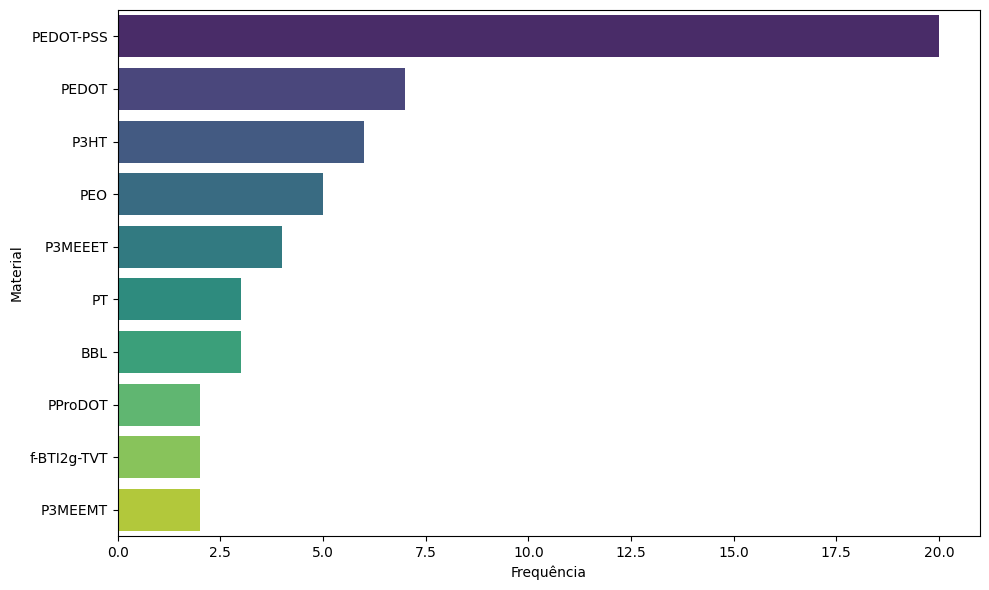

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

top_10_counts = corpus.value_counts().head(10)

# Ajustando o tamanho da figura
plt.figure(figsize=(10, 6))

# Plotando o histograma
sns.barplot(x=top_10_counts.values, y=top_10_counts.index, palette="viridis")
plt.xlabel('Frequência')
plt.ylabel('Material')

# Ajustando layout para não cortar legendas
plt.tight_layout()

# Salvando a imagem
#plt.savefig('gráficos/llama3-70B-OMIEC160824_RESPONSES_ranking.png')

# Exibindo a imagem
plt.show()


Tendência de publicações sobre a temática durante os anos

C:\Users\thaynara220042\AppData\Local\Temp\ipykernel_26476\3736620246.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


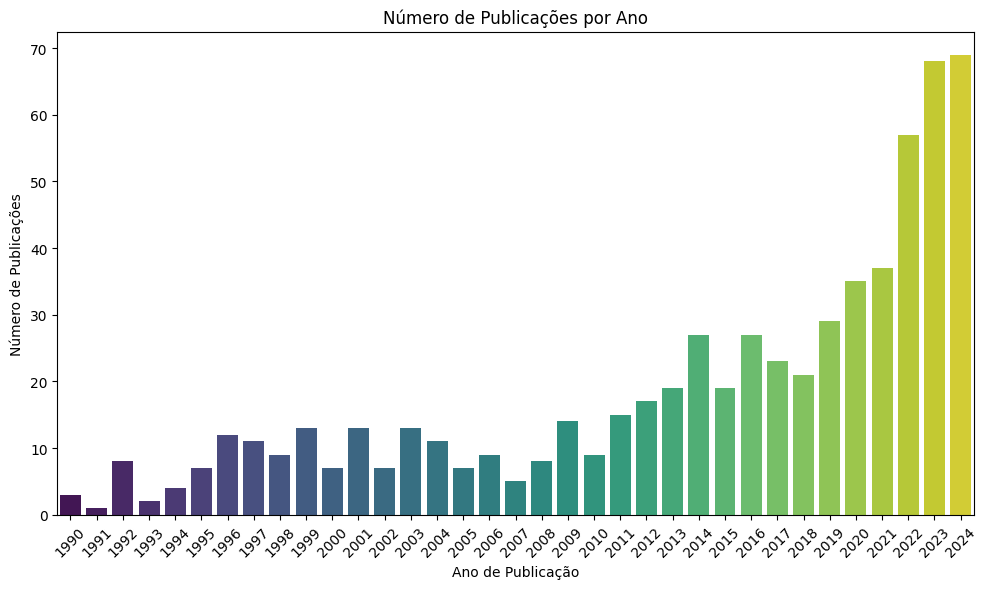

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supondo que 'raw_data' seja o seu DataFrame e 'Publication Year' seja a coluna com os anos de publicação
publication_counts = raw_data['Publication Year'].value_counts()

# Ordenar os valores pela data para melhorar a visualização (opcional)
publication_counts = publication_counts.sort_index()

# Criar o gráfico de barras com Seaborn usando a paleta "viridis"
plt.figure(figsize=(10, 6))
sns.barplot(
    x=publication_counts.index, 
    y=publication_counts.values, 
    palette="viridis"  # Aplica a paleta de cores "viridis"
)

# Configurar o título e os rótulos dos eixos
plt.title('Número de Publicações por Ano')
plt.xlabel('Ano de Publicação')
plt.ylabel('Número de Publicações')

# Mostrar o gráfico
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor visualização

# Ajustando layout para não cortar legendas
plt.tight_layout()

# Salvando a imagem
plt.savefig('gráficos/llama3-70B-OMIEC160824_publicação_por_ano.png')

plt.show()


Localizando os artigos em que aparecem os polímeros

In [30]:
polímeros_encontrados = pd.DataFrame(columns=['Nome'] + result.columns.tolist())

for index, row in result.iterrows():
    for token in set(str(row['response']).replace('\n', ';').split(';')):
            polimero = token.strip().replace('/', "-").replace(":", "-")
            new_row = row.to_dict() 
            new_row['Nome'] = polimero
            new_row_df = pd.DataFrame([new_row])
            polímeros_encontrados = pd.concat([new_row_df, polímeros_encontrados], ignore_index=True)

C:\Users\thaynara220042\AppData\Local\Temp\ipykernel_26476\4170896890.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  polímeros_encontrados = pd.concat([new_row_df, polímeros_encontrados], ignore_index=True)


In [31]:
for index, row in polímeros_encontrados[polímeros_encontrados['Nome'] == 'P3MEEET'].iterrows():
    print(row['Nome'],"| Citações:", row['Times Cited, All Databases'] , '\n', row['Abstract'], '\n')

P3MEEET | Citações: 93 
 Functionalizing conjugated polymers with polar ethylene glycol side chains enables enhanced swelling and facilitates ion transport in addition to electronic transport in such systems. Here, we investigate three polythiophene homopolymers (P3MEET, P3MEEMT, and P3MEEET) having differently linked (without spacer and with methyl and ethyl spacer, respectively) diethylene glycol side chains. All the polymers were tested in organic electrochemical transistors (OECTs). They show drastic differences in the device performance. The highest mu(OECT) C* product of 11.5 F/cm.V.s was obtained for ethyl-spaced P3MEEET. How the injection and transport of ions is influenced by the side-chain linkage was studied with electrochemical impedance spectroscopy, which shows a dramatic increase in volumetric capacitance from 80 +/- 9 up to 242 +/- 17 F/cm(3) on going from P3MEET to P3MEEET. Thus, ethyl-spaced P3MEEET exhibits one of the highest reported volumetric capacitance values am

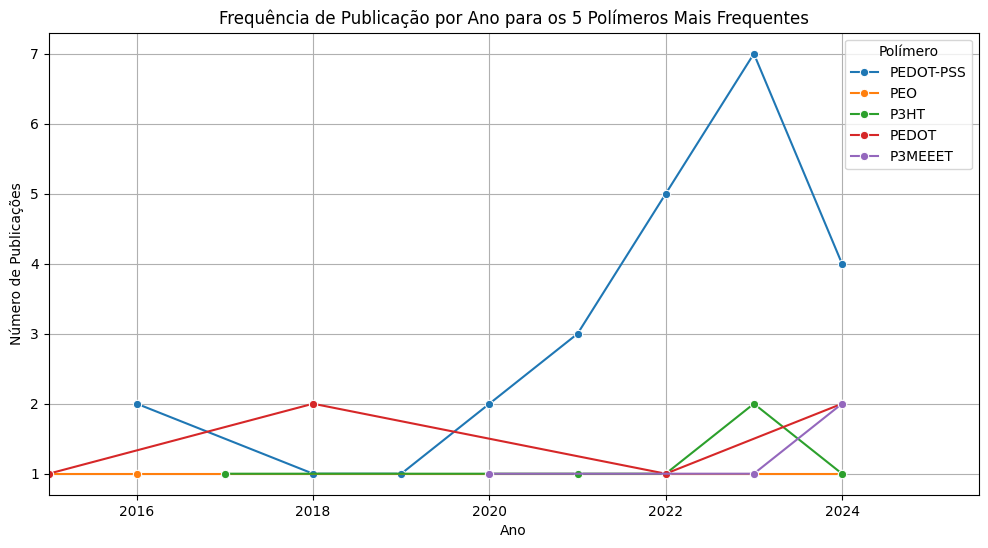

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

dfs = []


for polymer in corpus.value_counts().head(5).index:
    publication_counts = polímeros_encontrados[polímeros_encontrados['Nome'] == polymer]['Publication Year'].value_counts()
    publication_counts = publication_counts.sort_index().reset_index()
    publication_counts.columns = ['Year', 'Count']
    publication_counts['Polymer'] = polymer
    dfs.append(publication_counts)


combined_df = pd.concat(dfs)

plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x='Year', y='Count', hue='Polymer', marker='o')
plt.title('Frequência de Publicação por Ano para os 5 Polímeros Mais Frequentes')
plt.xlabel('Ano')
plt.ylabel('Número de Publicações')
plt.legend(title='Polímero')
plt.grid(True)

plt.xlim(left=2015)

plt.savefig('gráficos/llama3-70B-OMIEC160824_freq_publicação_polimero.png')

plt.show()


### Playground

In [20]:
for index, row in result.iterrows():    
    if not isinstance(row['response'], float) and  'PEDOT' in row['response']:
        print(row['response'], '\n', row['Abstract'], '\n' )

Mel; PEDOT:PSS 
 Organic mixed ionic-electronic conductors (OMIECs) can efficiently couple and transport ionic and electronic charge species, making them key elements for bioelectronics, neuromorphic computing, soft robotics, and energy storage applications. Here, we have synthesized a water-soluble, bio-inspired ion conductor melanin (Mel) and blended it with benchmark conducting polymer poly(3,4-ethylenedioxythiophene) polystyrene sulfonate (PEDOT:PSS) to form a new OMIEC. We explored the potential of Mel/PEDOT:PSS OMIEC blends in two critical device applications: organic electrochemical transistors (OECTs) and supercapacitors (SuperCaps). Mel incorporation into PEDOT:PSS enhances the ionic-electronic coupling when ions from an electrolyte are injected into the material, increasing the volumetric capacitance of PEDOT:PSS films ten-fold. The addition of Mel in PEDOT:PSS also increases the transconductance of OECTs (from 7 +/- 1 to 11 +/- 3 mS), and the energy and power densities of Su

Tendência de publicações por ano plotado com plotly

In [17]:
import plotly.express as px

# Supondo que 'raw_data' seja o seu DataFrame e 'Publication Year' seja a coluna com os anos de publicação
publication_counts = raw_data['Publication Year'].value_counts()

# Ordenar os valores pela data para melhorar a visualização (opcional)
publication_counts = publication_counts.sort_index()

# Criar o gráfico de barras com Plotly
fig = px.bar(
    x=publication_counts.index, 
    y=publication_counts.values, 
    labels={'x': 'Publication Year', 'y': 'Number of Publications'},
    title='Number of Publications per Year',
    color=publication_counts.index,  # Adiciona cor baseado no índice (ano de publicação)
    color_continuous_scale='viridis'  # Aplica a paleta "viridis"
)

# Configurar o layout
fig.update_layout(
    xaxis=dict(tickangle=45),  # Rotaciona os rótulos do eixo x para melhor visualização
    yaxis_title='Number of Publications',
    xaxis_title='Publication Year',
    coloraxis_showscale=False  # Oculta a barra de escala de cores, se indesejado
)

# Mostrar o gráfico
fig.show()
